In [1]:
import random
import gc
from itertools import chain
import seaborn as sns
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torchvision import transforms as transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# user modules
import sys
import os
from os import path
sys.path.append(path.dirname(path.abspath('')))
from models.wideresnet import WideResNet
from models.resnet import ResNet9, ResNet50
import metrics.similarity as sim
from data.partition import partition_data, get_partition_dict
from data.datasets import load_cifar10_data
from data.dataloader import get_dataloader

In [3]:
device = torch.device('cuda')

In [4]:
def find_ckpt(expname, comm, modeldir='../ckpt', epoch=None, client=None):
    f = filter(lambda x: expname in x, os.listdir(modeldir))
    f = filter(lambda x: f'comm{comm:03}' in x, f)
    if client is None:
        f = filter(lambda x: f'GLOBAL' in x, f)
    else:
        if epoch:
            f = filter(lambda x: f'epoch{epoch:03}' in x, f)
        f = filter(lambda x: f'CLIENT{client:02}' in x, f)
    return list(f)[0]

In [5]:
def extract_repr(model, dataset, layers, n_samples, device):
    reprs = []
#     def pre_hook(module, input_):
#         reprs.append(input_)
    def hook(module, input_, output):
#         print(f'hook executed in {module}')
        reprs.append(output)
    if layers is not None:
        modules = [v for k, v in model.named_modules() if k in layers]
    else:
        modules = [v for k, v in model.named_modules()]
#     print(f'Registered hook for {len(modules)} modules.')
    for module in modules:
        module.register_forward_hook(hook)

    with torch.no_grad():
        ds = [data for data, target in dataset]
#         random.shuffle(ds)
        data = torch.stack(ds[:n_samples])
        if device:
            model = model.to(device)
            data = data.to(device)
        model(data)
#     return [rep.view(rep.shape[0], -1).to(device) for rep in reprs]
    return [rep.to(device) for rep in reprs]

In [6]:
def channelwise_CKA(X, Y=None, device=None):
    size = len(X)
    mat = np.zeros((size, size))
    if Y is None:
        Y=X
    X=X.to(device)
    Y=Y.to(device)
    for i in tqdm(range(size)):
        for j in range(size):
            mat[i][j] = sim.kernel_CKA(X[i].view(len(X[i]), -1), Y[j].view(len(Y[i]), -1), device=device)
    return mat

def clientwise_CKA(cl_a, cl_b, n_samples=256, device=None):
    size = len(X)
    mat = np.zeros((size, size))
    if Y is None:
        Y=X
    for i in tqdm(range(size)):
        for j in range(size):
            mat[i][j] = sim.kernel_CKA(X[i].view(len(X[i]), -1), Y[j].view(len(Y[i]), -1), device=device)
    return mat

In [7]:
def calc_sim(model_a, model_b,  dataset_a, dataset_b=None, layers_a=None, layers_b=None, n_samples=256, device=None):
#     assert model_a == model_b
#     assert dataset_a == dataset_b
#     assert layers_a == layers_b
    dataset_b = dataset_b or dataset_a
    reprs_a= extract_repr(model_a, dataset_a, layers_a, n_samples, device=device)
    reprs_b= extract_repr(model_b, dataset_b, layers_b, n_samples, device=device)
    cka = np.zeros((len(reprs_a), len(reprs_b)))
    i=0
    for r_a in tqdm(reprs_a):
        j=0
        for r_b in reprs_b:
            with torch.no_grad():
                cka[i,j] = kernel_CKA(r_a, r_b, device=device)
            j+=1
        i+=1
    return cka

In [8]:
def plot(sim, path):
    plt.figure(figsize=(30, 15), dpi=200)
    axes = plt.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
    axes.axes.invert_yaxis()
    if path:
        plt.savefig(path, dpi=400)

In [9]:
'''
cnum_a, cnum_b: -1 means global
dsetnum_a, dsetnum_b: -1 means testset
'''
def compare_model(
    cnum_a, cnum_b, dsetnum_a, dsetnum_b,
    comm_round, partition, expname,
    datadir='~/data', modeldir='../ckpt',
    model=None,
    num_classes=10,
    epoch=None,
    device=torch.device('cuda')
):
    # load dataset index map
    target_idx = dsetnum_a
    if dsetnum_a<0:
        target_idx = 0
    net_dataidx_map = get_partition_dict('cifar10', partition, 10, datadir='~/data', init_seed=0)
    _, _, trainset, testset= get_dataloader(
        'cifar10', '~/data', 256, 32,
        net_dataidx_map[target_idx], 0, augment=False
    )
    dset_a = testset if dsetnum_a<0 else trainset
        
    if dsetnum_a == dsetnum_b:
        dset_b = dset_a
    elif dsetnum_b<0:
        dset_b = testset
    else:
        _, _, trainset, testset= get_dataloader(
            'cifar10', '~/data', 256, 32,
            net_dataidx_map[dsetnum_b], 0, augment=False
        )
        dset_b = trainset

    # model to compare
    net_a = model(num_classes=num_classes)
    net_a.load_state_dict(torch.load(
        os.path.join(modeldir, find_ckpt(expname, comm=comm_round, client=cnum_a if cnum_a>=0 else None, modeldir=modeldir, epoch=epoch))
    ))
    if cnum_a == cnum_b:
        net_b = net_a
    else:
        net_b= model(num_classes=num_classes)
        net_b.load_state_dict(torch.load(
            os.path.join(modeldir, find_ckpt(expname, comm=comm_round, client=cnum_b if cnum_b>=0 else None, modeldir=modeldir, epoch=epoch))
        ))
        
    cond = lambda x: 'activation' in x
#     cond = lambda x: ('conv' in x) or ('batchnorm' in x) or ('activation' in x)
    layers_a = [k for k, v in net_a.named_modules() if cond(v.__module__)]
    layers_b = [k for k, v in net_b.named_modules() if cond(v.__module__)]
    
    try:
        cka = calc_sim(
            net_a, net_b, dataset_a=dset_a, dataset_b=dset_b, layers_a=layers_a, layers_b=layers_b, device=device
        )
    finally:
        del net_a, net_b, dset_a, dset_b
        gc.collect()
        torch.cuda.empty_cache()
    return cka

In [10]:
# Dataset PreP
net_dataidx_map = get_partition_dict('cifar10', 'homo', 10, datadir='~/data', init_seed=0)
_, _, trainset, testset= get_dataloader(
    'cifar10', '~/data', 256, 32,
    net_dataidx_map[0], 0, augment=False
)

In [58]:
from copy import copy
dummyset = copy(testset)
dummyset.data = (np.random.rand(*testset.data.shape)*255).astype(np.uint8)

In [13]:
def compare_ce_orth(cl_num, layeridx, comm, dataset, samples=256):
    ckpt = find_ckpt('WRN-28-10-CE', comm=comm, client=cl_num)
    # load model
    model=WideResNet(28, 10, 10)
    model.load_state_dict(torch.load(f'../ckpt/{ckpt}'))

    # Select layer
    cond = lambda x: 'activation' in x
    layers = [k for k, v in model.named_modules() if cond(v.__module__)]
    layer = layers[layeridx]
    print(layer)

    # extract repr
    rep_ce = extract_repr(model, dataset, [layer], samples, 'cuda')

    # model 2
    ckpt = find_ckpt('WRN-28-10-ORTH', comm=comm, client=cl_num)
    model.load_state_dict(torch.load(f'../ckpt/{ckpt}'))
    rep_orth = extract_repr(model, dataset, [layer], samples, 'cuda')

    a = channelwise_CKA(
        rep_ce[0].swapaxes(0,1),
        rep_ce[0].swapaxes(0,1),
        'cuda'
    )
    b = channelwise_CKA(
        rep_orth[0].swapaxes(0,1),
        rep_orth[0].swapaxes(0,1),
        'cuda'
    )

    # client 0, 'block1.layer.0.relu2', channelwise
    print('Mean cka(except self)')
    print(f'A: {(np.sum(a)-a.shape[0])/(a.size-a.shape[0]):.2f}')
    print(f'B: {(np.sum(b)-b.shape[0])/(b.size-b.shape[0]):.2f}')
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
    sns.heatmap(a, ax=axes[0][0])
    sns.heatmap(b, ax=axes[0][1])
    sns.histplot(a.flatten(), ax=axes[1][0])
    sns.histplot(b.flatten(), ax=axes[1][1])
    plt.show()

block1.layer.0.relu2


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Mean cka(except self)
A: 0.51
B: 0.45


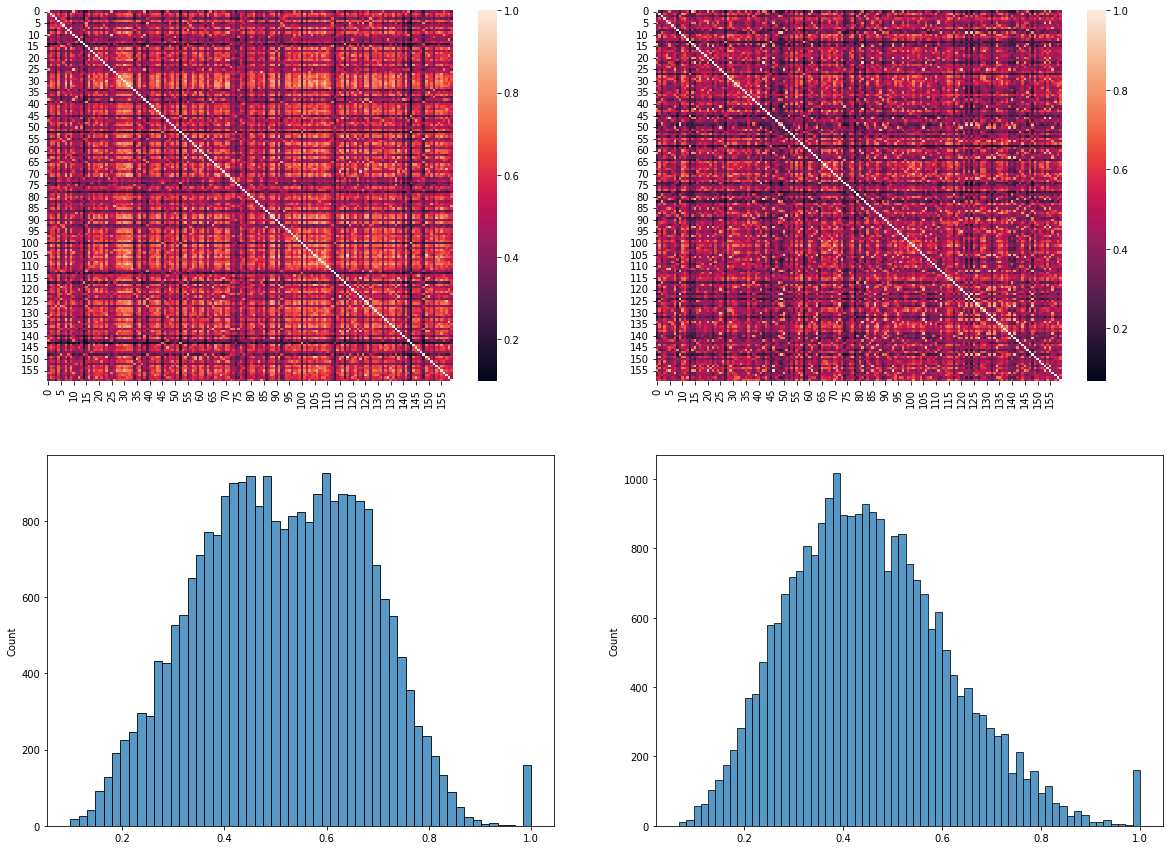

In [100]:
compare_ce_orth(cl_num=0, layeridx=1, comm=10, dataset=testset, samples=256)

block1.layer.0.relu2


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Mean cka(except self)
A: 0.50
B: 0.42


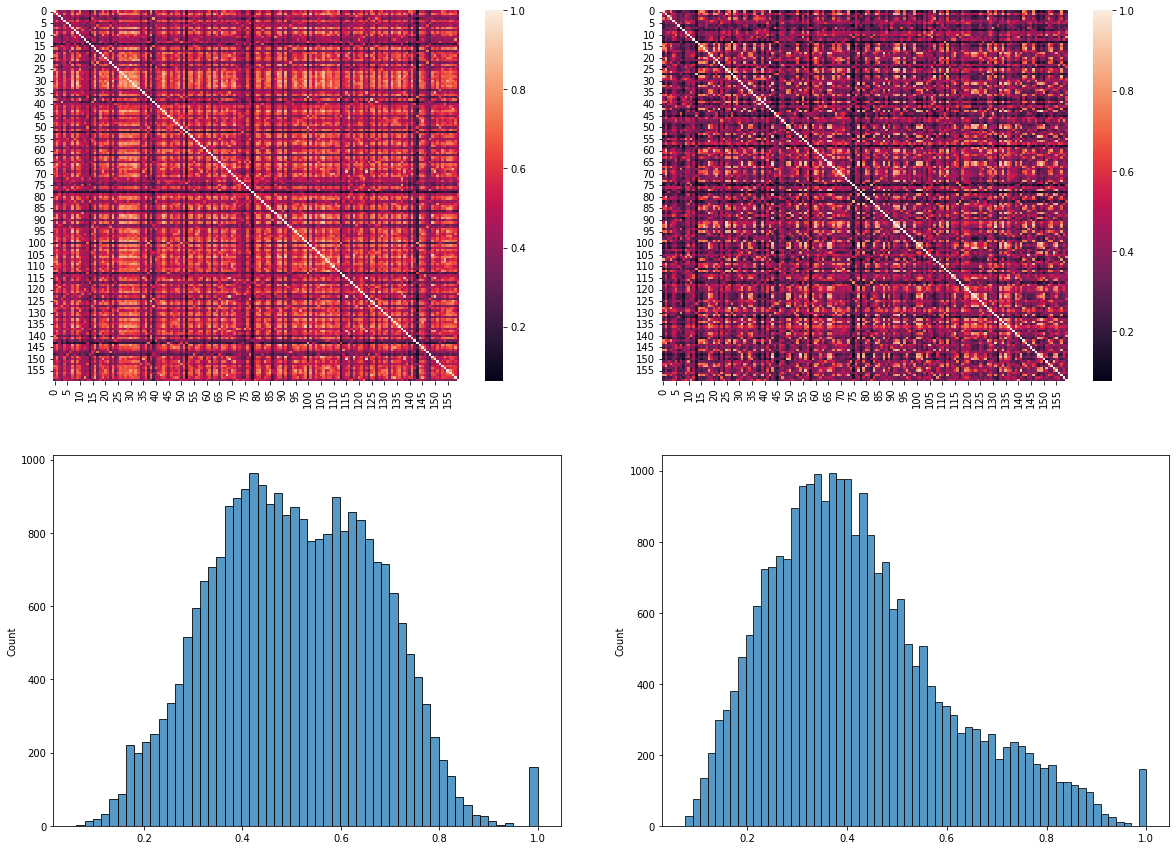

In [114]:
compare_ce_orth(cl_num=0, layeridx=1, comm=20, dataset=testset, samples=256)

block1.layer.0.relu2


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Mean cka(except self)
A: 0.48
B: 0.40


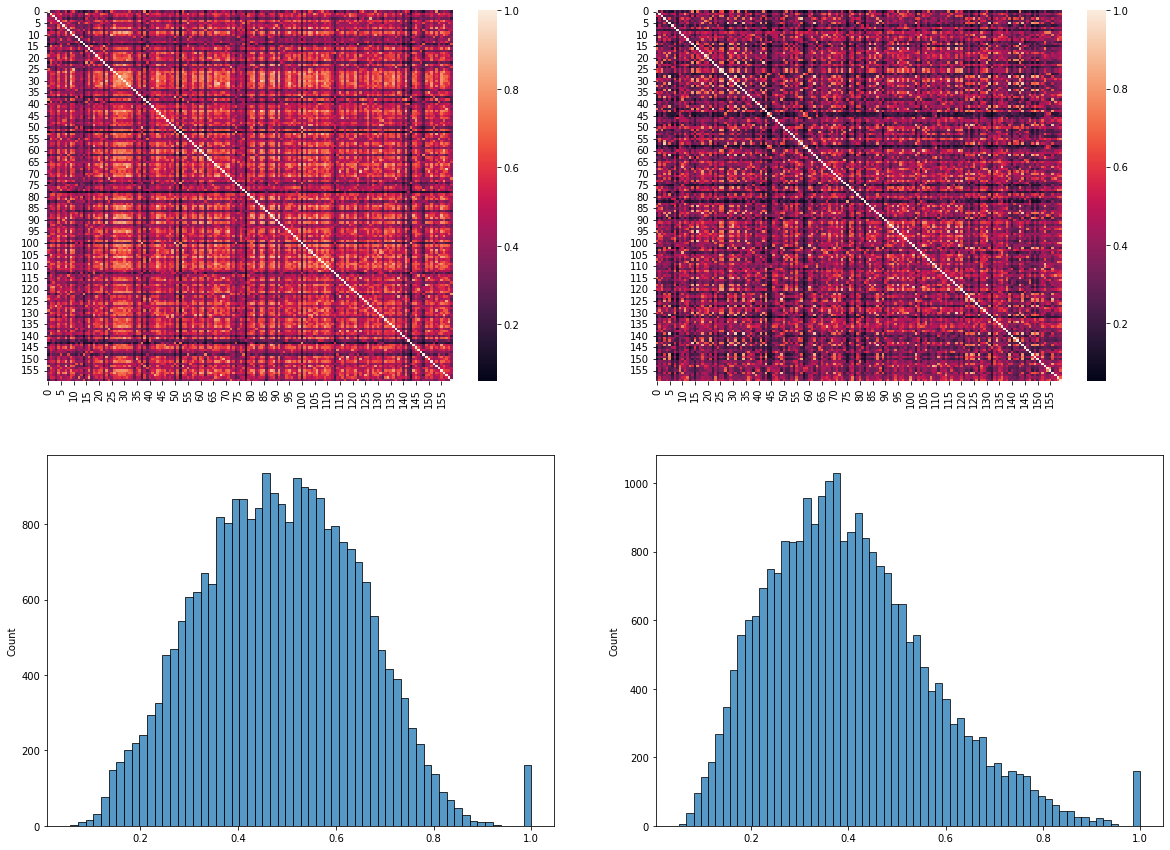

In [14]:
compare_ce_orth(cl_num=0, layeridx=1, comm=40, dataset=testset, samples=256)

block1.layer.1.relu1


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Mean cka(except self)
A: 0.78
B: 0.69


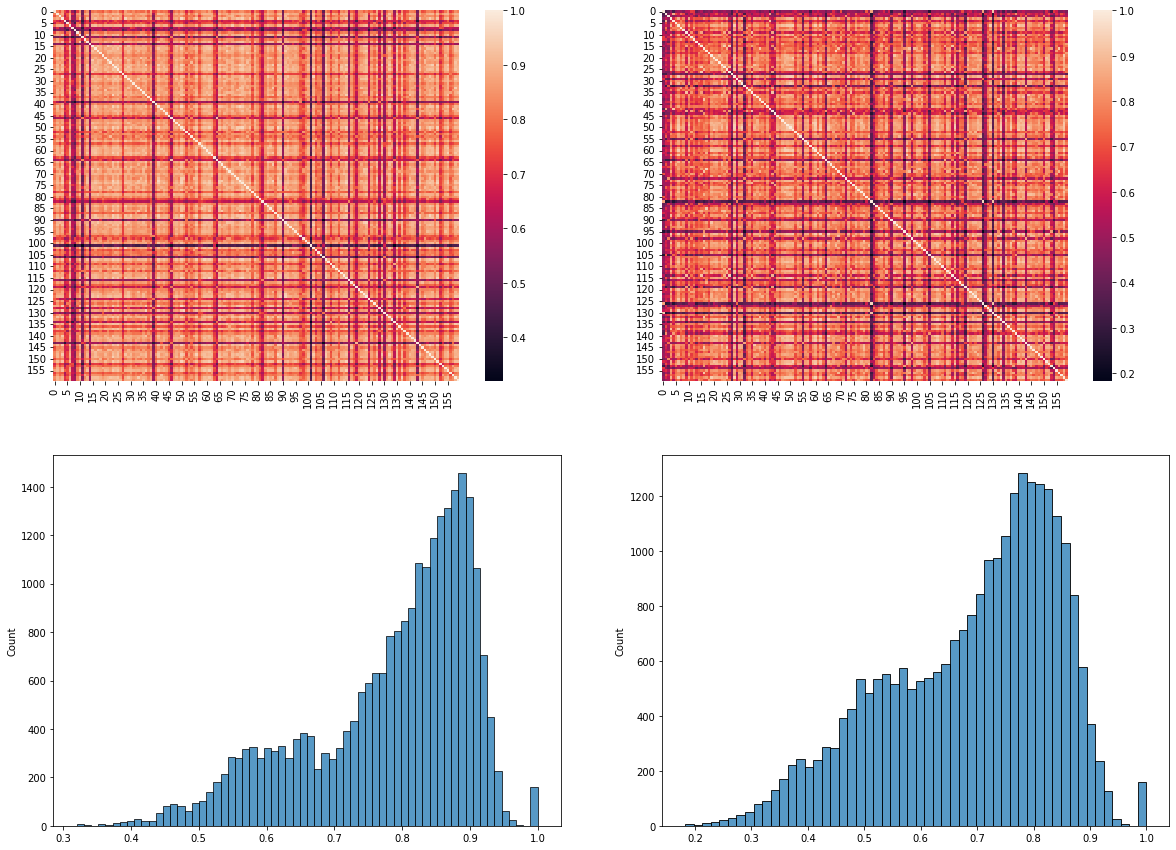

In [72]:
compare_ce_orth(cl_num=0, layeridx=2, comm=50, dataset=testset, samples=64)

relu


  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Mean cka(except self)
A: 0.23
B: 0.23


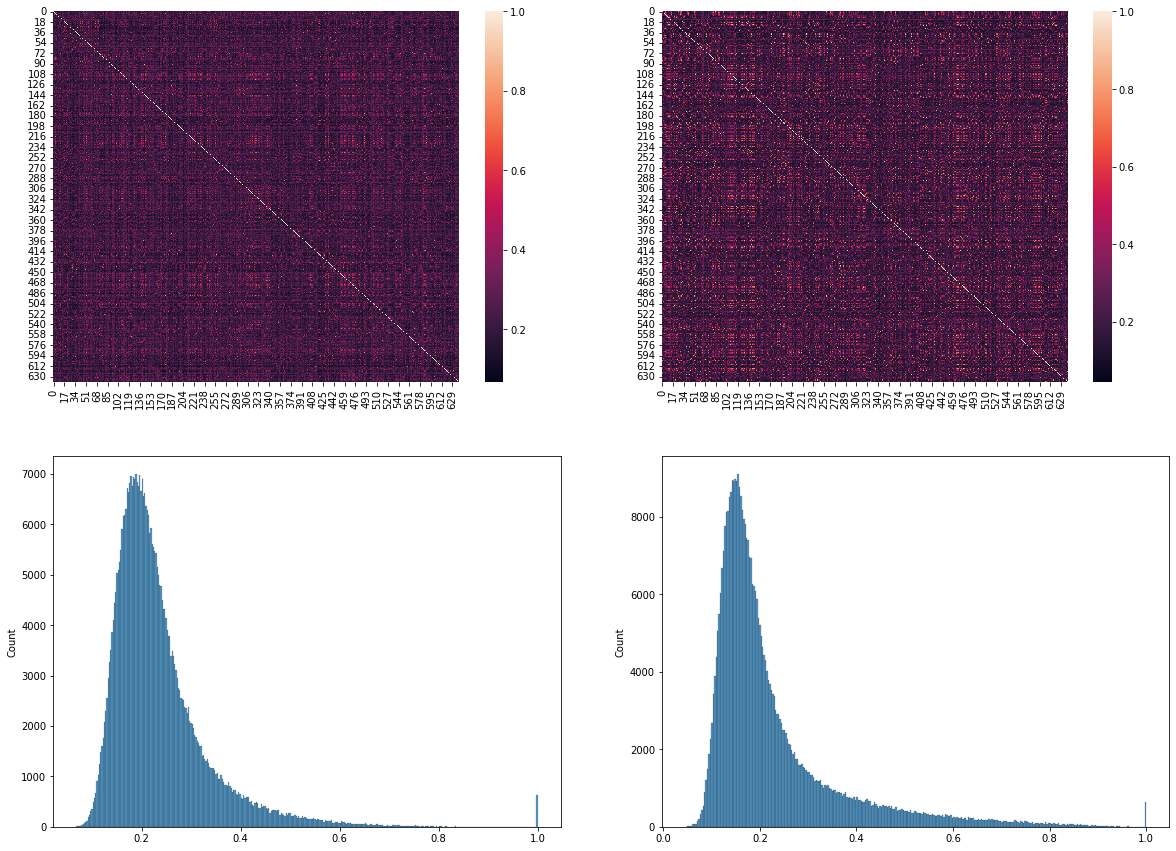

In [73]:
compare_ce_orth(cl_num=0, layeridx=-1, comm=50, dataset=testset, samples=64)

block2.layer.3.relu2


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

Mean cka(except self)
A: 0.64
B: 0.63


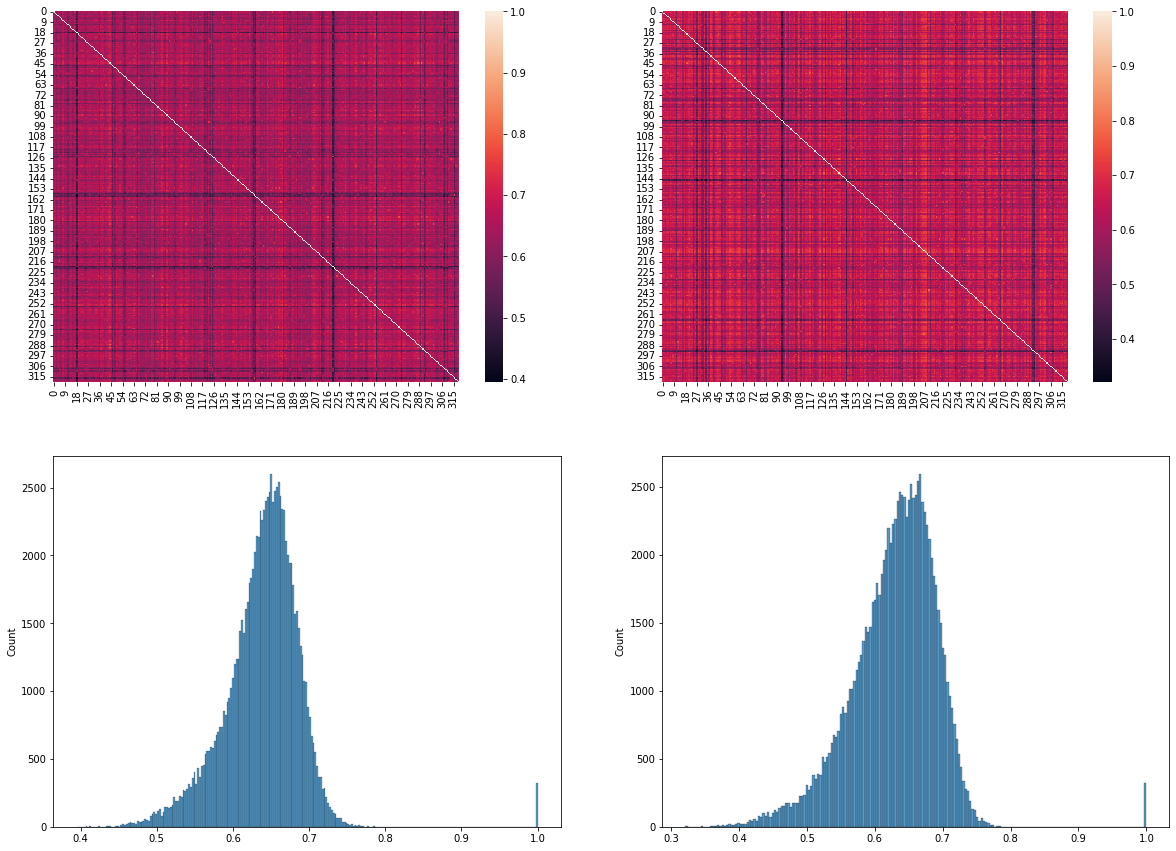

In [74]:
compare_ce_orth(cl_num=0, layeridx=-10, comm=50, dataset=testset, samples=64)

block1.layer.3.relu2


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Mean cka(except self)
A: 0.89
B: 0.90


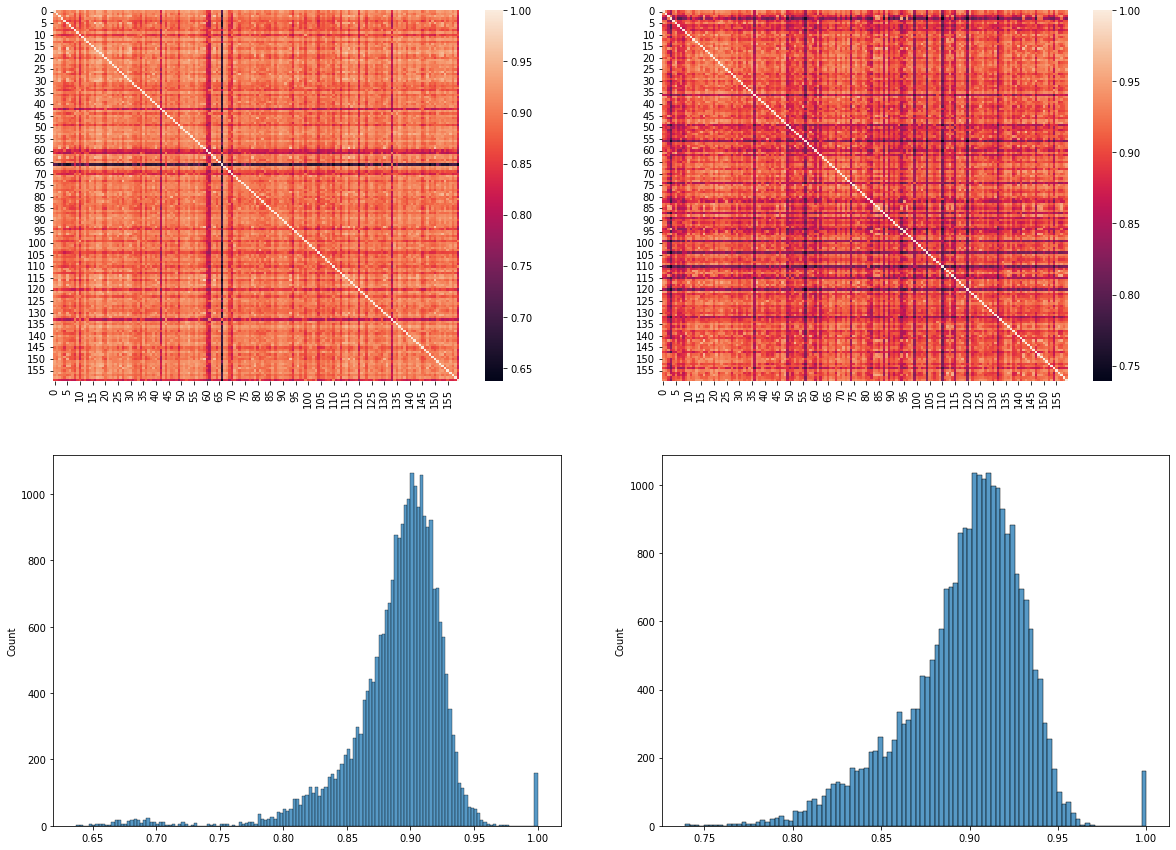

In [71]:
compare_ce_orth(cl_num=0, layeridx=7, comm=50, dataset=testset, samples=64)

In [70]:
model=WideResNet(28, 10, 10)
cond = lambda x: 'activation' in x
layers = [k for k, v in model.named_modules() if cond(v.__module__)]
layer = layers[7]
print(layer)

block1.layer.3.relu2


In [ ]:
ckpt = find_ckpt('WRN-28-10-CE', comm=comm, client=cl_num)
# load model
model=WideResNet(28, 10, 10)
model.load_state_dict(torch.load(f'../ckpt/{ckpt}'))

# Select layer
cond = lambda x: 'activation' in x
layers = [k for k, v in model.named_modules() if cond(v.__module__)]
layer = layers[layeridx]
print(layer)

# extract repr
rep_ce = extract_repr(model, dataset, [layer], samples, 'cuda')

# model 2
ckpt = find_ckpt('WRN-28-10-ORTH', comm=comm, client=cl_num)
model.load_state_dict(torch.load(f'../ckpt/{ckpt}'))
rep_orth = extract_repr(model, dataset, [layer], samples, 'cuda')

a = channelwise_CKA(
    rep_ce[0].swapaxes(0,1),
    rep_ce[0].swapaxes(0,1),
    'cuda'
)
b = channelwise_CKA(
    rep_orth[0].swapaxes(0,1),
    rep_orth[0].swapaxes(0,1),
    'cuda'
)